<a href="https://colab.research.google.com/github/AchrafAsh/gnn-receptive-fields/blob/main/06_khop_with_embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

After some reflection (and seeing that our model had way too many parameters), we realised something weird happening in the design of Graph Neural Networks.
Most GNNs, if not all, are embedding the input features in the first layer which has a receptive field containing only the direct neighbors.
It leads to a very biased embedding (100% attention from the direct neighbors) which could potentially cause a loss of information that is irrelevant for the direct neighbors, but highly relevant for remote ones or even for the task at hand.

Because our approach required to compute new embeddings for each k-hop neighborhood, we realised that this was not an ideal way of computing embeddings.

In this notebook, we try to design a new Message Passing GNN with an initial MLP that serves as an embedding layer from which we then operate our different convolutional layers.

## **🚀 Setting up the environment**

In [1]:
import os, sys
import os.path as osp
from google.colab import drive
drive.mount('/content/mnt')
nb_path = '/content/notebooks'
try:
    os.symlink('/content/mnt/My Drive/Colab Notebooks', nb_path)
except:
    pass
sys.path.insert(0, nb_path)  # or append(nb_path)

Mounted at /content/mnt


In [85]:
# import everything
import math
import random
import copy
import time
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F

from functools import partial
from tqdm.notebook import tqdm
from typing import Dict, List, Tuple
from torch_geometric.utils import degree, to_dense_adj, dense_to_sparse, add_self_loops
from torch_geometric.nn import GCNConv, MessagePassing, Sequential
from sklearn.metrics import pairwise_distances
from sklearn.manifold import TSNE

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

%matplotlib inline
sns.set_style('darkgrid')
palette = sns.color_palette("hls", cora_dataset.num_classes)

In [3]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

## **🎨 Designing the model**

#### K-hop GCNConv

In [76]:
class HopGCNConv(MessagePassing):
    def __init__(self, num_features:int, in_channels:int, out_channels:int, k:int):
        super(HopGCNConv, self).__init__(aggr='add')  # "Add" aggregation
        self.k = k
        self.lin_input = torch.nn.Linear(num_features, out_channels)
        self.lin_hidden = torch.nn.Linear(in_channels, out_channels)
        
        self.reset_parameters()
        
    def reset_parameters(self):
        xavier(self.lin_input.weight)
        zeros(self.lin_input.bias)
        
        xavier(self.lin_hidden.weight)
        zeros(self.lin_hidden.bias)

    def forward(self, x, h, edge_index):
        # x is the input features and has shape [N, num_features]
        # h is the hidden state and has shape [N, in_channels]
        # edge_index has shape [2, E] , E being the number of edges

        # step 1: linearly transform node feature matrices
        x = self.lin_input(x)
        h = self.lin_hidden(h)

        # step 3-5: start propagating messages
        return self.propagate(edge_index[self.k], x=x, h=h)

    def message(self, x_j, h_i, edge_index, size):
        # x_j is the input features of the neighbors and has shape [E, out_channels] (has already been multiplied by the weight matrix)

        # step 3: normalize node features
        row, col = edge_index
        deg = degree(row, size[0], dtype=x_j.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        out = norm.view(-1, 1) * x_j

        return out + h_i
        # add the hidden state of the target node
        # norm = deg_inv_sqrt[row] * deg_inv_sqrt[row]
        
        # return out + norm.view(-1, 1) * h_i

    def update(self, aggr_out):
        # aggr_out has shape [N, out_channels] is the output of self.message()

        # step 5: return new node embeddings
        return aggr_out

#### Our model

In [137]:
# the real deal
class KHopNet(torch.nn.Module):
    def __init__(self, num_layers:int, hidden_dim:int, num_features:int, num_classes:int, dropout:float=0.5, invert:bool=False):
        super().__init__()

        # Embedding input features
        self.in_mlp = torch.nn.Sequential(
            torch.nn.Linear(in_features=num_features, out_features=256),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=256, out_features=hidden_dim),
            torch.nn.ReLU()
        )
        
        # Convolutional layers
        self.conv_layers = self.create_layers(num_layers=num_layers,
                                              hidden_dim=hidden_dim,
                                              dropout=dropout,
                                              invert=invert)
        
        # Readout function
        # self.out_mlp = torch.nn.Sequential(
        #     torch.nn.Linear(in_features=hidden_dim, out_features=hidden_dim),
        #     torch.nn.ReLU(),
        #     torch.nn.Linear(in_features=hidden_dim, out_features=num_classes),
        #     torch.nn.LogSoftmax(dim=1)
        # )
        self.out_gcn = GCNConv(hidden_dim, num_classes)
        self.log_softmax = torch.nn.LogSoftmax(dim=1)


    def create_layers(self, num_layers:int, hidden_dim:int, dropout:float, invert:bool):
        layers = [(HopGCNConv(num_features=hidden_dim, in_channels=hidden_dim, out_channels=hidden_dim, k=0), "x, x, edge_index -> h"),
                (torch.nn.BatchNorm1d(hidden_dim), "h -> h ")
                (torch.nn.ReLU(), "h -> h"),
                (torch.nn.Dropout(p=dropout), "h -> h")]
        
        for k in range(1, num_layers):
            layers += [
                (HopGCNConv(num_features=hidden_dim, in_channels=hidden_dim, out_channels=hidden_dim, k=k), "x, h, edge_index -> h"),
                (torch.nn.BatchNorm1d(hidden_dim), "h -> h")
                (torch.nn.ReLU(), "h -> h"),
                (torch.nn.Dropout(p=dropout), "h -> h")
            ]
        return Sequential("x, edge_index", layers)


    def reset_parameters(self):
        self.conv_layers.reset_parameters()


    def forward(self, x, edge_index):
        embeddings = self.in_mlp(x)
        h = self.conv_layers(embeddings, edge_index)
        return h, self.log_softmax(self.out_gcn(h, edge_index[0]))

In [75]:
def make(config):
    # Make the model
    model = KHopNet(num_layers=config.num_layers, hidden_dim=config.hidden_dim,
                    num_features=cora_dataset.num_features,
                    num_classes=cora_dataset.num_classes,
                    dropout=config.dropout).to(device)

    # Make the loss and optimizer
    criterion = torch.nn.NLLLoss()
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=config.learning_rate,
                                 weight_decay=config.weight_decay)
    
    return model, criterion, optimizer

## **🧰 Utility functions**

In [4]:
def get_k_neighbors(k: int):
    """Returns the l-hop neighbors for l between 1 (the adjacency matrix) and k (given depth)

    Args:
        - adj: dense adjacency matrix
        - k (int): size of the maximum neighborhood
    """
    
    output = [G.edge_index]
    dense_adj = to_dense_adj(G.edge_index).squeeze(0)
    dense_nebs = [dense_adj.clone()]
    adj_pow = dense_adj.clone()

    for l in tqdm(range(1, k)):
        adj_pow = torch.mm(dense_adj, adj_pow)
        k_neb = torch.where(
            torch.where(adj_pow > 0, 1, 0) - sum(dense_nebs) > 0,
            1,
            0
        )
        dense_nebs.append(k_neb)
        output.append(dense_to_sparse(k_neb)[0])
    
    return output

In [86]:
def tsne_plot(model: torch.nn.Module, all_edge_index:list, title:str):
    # Representing the representations with t-SNE algorithm
    h, logits = model(G.x, all_edge_index)
    representations = TSNE().fit_transform(h.detach().numpy())
    
    # Plot the 2-D representations, both with true labels and predictions
    fig, ax = plt.subplots(1, 2, figsize=(24, 8))
    fig.suptitle(title, fontsize=20)

    sns.scatterplot(x=representations[:,0], y=representations[:,1], hue=logits.argmax(dim=1), legend='full', palette=palette, ax=ax[0]).set(title="Predictions")
    sns.scatterplot(x=representations[:,0], y=representations[:,1], hue=G.y, legend='full', palette=palette, ax=ax[1]).set(title="True labels")
    
    fig.show()

In [87]:
def model_pipeline(hyperparameters):
    with wandb.init(project='gnn-receptive-fields', entity='achraf', config=hyperparameters):
        config = wandb.config # to make sure we use what is saved in wandb

        # create the model
        model, criterion, optimizer = make(config)
        count_parameters(model)
        
        # compute different depth edge_index
        all_edge_index = get_k_neighbors(config.num_layers)

        # train the model
        train(model, all_edge_index, criterion, optimizer, config)

        tsne_plot(model, all_edge_index, title="Last hidden representations")

        # Save the model in the exchangeable ONNX format → not working... yet
        # torch.onnx.export(model, G, "model.onnx")
        # wandb.save("model.onnx")

    return model

In [6]:
# Parameter initialization
def xavier(tensor):
    """Initialize weight matrix with Xavier distribution

    Args:
        tensor (tensor): weigh matrix
    Return:
        tensor - weight matrix initialized
    """
    if tensor is not None:
        stdv = math.sqrt(6.0 / (tensor.size(-2) + tensor.size(-2)))
        tensor.data.uniform_(-stdv, stdv)


def zeros(tensor):
    """Initialize bias vector with all zeros

    Args:
        tensor (tensor): bias vector
    
    Return
        tensor - bias vector initialized with zeros
    """
    if tensor is not None:
        tensor.data.fill_(0)

In [10]:
# count model parameters
def count_parameters(model: torch.nn.Module):
    print(f"The model has {sum(p.numel() for p in model.parameters() if p.requires_grad):,} parameters")

In [60]:
def train(model, all_edge_index, criterion, optimizer, config):
    # tell wandb to watch what the model gets up to: gradients, weights, and more!
    wandb.watch(model, criterion, log="all", log_freq=10)

    # Run training and track with wandb
    dense_adj = to_dense_adj(G.edge_index).squeeze(0)
    for epoch in tqdm(range(config.epochs)):
        loss = train_step(model, all_edge_index, optimizer, criterion)
        
        # test the model
        test(model, all_edge_index, metrics=[('mad', mad_value),
                                             ('mad_gap', partial(mad_gap_value,dense_adj)),
                                             ('mad_sp', shortest_path_mad)])


def train_step(model, all_edge_index, optimizer, criterion):
    """Performs one training step
    """
    model.train()
    
    # Forward pass
    _, out = model(G.x, all_edge_index)
    loss = criterion(out[G.train_mask], G.y[G.train_mask])
    
    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss

In [51]:
def test(model, all_edge_index, metrics=[]):
    """
    Metrics is a list of tuple ('metric_name', metric_func) where the metric 
    function takes the last representation matrix and returns a scalar.
    """

    model.eval()

    # Run the model on some test examples
    with torch.no_grad():
        h, logits = model(G.x, all_edge_index)

    outs = {}
    for (name, metric) in metrics:
        outs[name] = metric(h)

    for key in ['train', 'val', 'test']:
        mask = G[f'{key}_mask']
        loss = F.nll_loss(logits[mask], G.y[mask]).item()
        pred = logits[mask].max(1)[1]
        acc = pred.eq(G.y[mask]).sum().item() / mask.sum().item()

        outs[f'{key}_loss'] = loss
        outs[f'{key}_acc'] = acc
    
    wandb.log(outs)
    
    return outs

#### Over-smoothing metrics

In [64]:
def mad_value(in_arr, mask_arr=None, distance_metric='cosine', digt_num=4, target_idx=None):
    """The numpy version for mad (able to compute quickly)

    Args:
        - in_arr [num_nodes, hidden_dim]: the node feature matrix
        - mask_arr [num_nodes, num_nodes]: the mask matrix of the target relations (is it the adjacency matrix?)
        - target_idx [1, 2, 3, ...n]: the nodes indices for which we calculate the mad value
    """

    if mask_arr == None:
        mask_arr = torch.ones(in_arr.size(0), in_arr.size(0))

    dist_arr = pairwise_distances(in_arr, in_arr, metric=distance_metric)
    mask_dist = np.multiply(dist_arr, mask_arr)
    divide_arr = (mask_dist != 0).sum(1) + 1e-8
    
    node_dist = mask_dist.sum(1) / divide_arr
    if target_idx==None:
        mad = node_dist.mean()
    else:
        node_dist = np.multiply(node_dist,target_idx)
        mad = node_dist.sum()/((node_dist!=0).sum()+1e-8)

    try:
        mad = round(mad, digt_num)
    except:
        pass

    return mad

In [53]:
def mad_gap_value(adj, in_arr):
    """Simple version of the MADGap metric implementation

    Args:
        - in_arr [node_num, hidden_dim]: the node feature matrix
        - adj [node_num, node_num]: dense adjacency matrix
    """

    mad_neb = mad_value(in_arr=in_arr, mask_arr=adj)
    mad_rmt = mad_value(in_arr=in_arr, mask_arr=1-adj)

    return (mad_rmt - mad_neb).item()

In [54]:
import networkx as nx
from torch_geometric.utils import to_networkx

In [55]:
def get_shortest_path_lengths():
    g = to_networkx(G)
    shortest_paths = nx.shortest_path_length(g)

    sp_matrix = torch.zeros((G.num_nodes, G.num_nodes), dtype=int)

    for node_idx, path_lengths in shortest_paths:
        for (idx, len) in path_lengths.items():
            sp_matrix[node_idx, idx] = len
    
    return sp_matrix

In [56]:
shortest_path_lens = get_shortest_path_lengths()
shortest_path_mask = torch.where(shortest_path_lens == 0, torch.tensor(0, dtype=torch.float32), 1/shortest_path_lens)

In [57]:
def shortest_path_mad(in_arr):
    """Computes MAD of all node with shortest path normalization

    Args:
        - h [num_nodes, num_nodes]: representation matrix
    """
    
    return mad_value(in_arr=in_arr,
                     mask_arr=shortest_path_mask)

## **🧪 Run experiments**

#### Import Cora

In [15]:
%%capture
!wget https://raw.githubusercontent.com/AchrafAsh/gnn-receptive-fields/main/data.py

from data import load_dataset

path = osp.join(os.getcwd(), 'data')
cora_dataset = load_dataset(path, 'Cora')
G = cora_dataset[0] # only graph of the dataset

#### Run pipeline

In [96]:
config = dict(
    num_layers=2,
    hidden_dim=16,
    epochs=200,
    learning_rate=0.001,
    weight_decay=1e-5,
    dropout=0.5)

wandb: wandb version 0.10.33 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


The model has 372,423 parameters


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

mad,0.41957
mad_gap,0.15384
mad_sp,0.07404
train_loss,0.80195
train_acc,0.86429
val_loss,3.00757
val_acc,0.398
test_loss,2.5244
test_acc,0.435
_runtime,115
_timestamp,1625670587


mad,█▇▂▁▁▁▂▄▄▄▄▄▅▅▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇██████
mad_gap,▃▂▁▁▂▂▄▅▅▆▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇█▇▇████
mad_sp,█▇▂▂▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆
train_loss,█▆▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
train_acc,▁▁▃▃▃▃▃▃▄▄▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇█▇███████
val_loss,▇▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▃▃▃▄▃▄▄▄▅▅▅▅▆▆▇█▇█
val_acc,▂▁▃▃▂▄▄▄▄▄▄▅▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████▇
test_loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▅▅▆▆▅▆
test_acc,▂▁▃▄▃▄▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇▇▇▇█▇█▇████████████
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


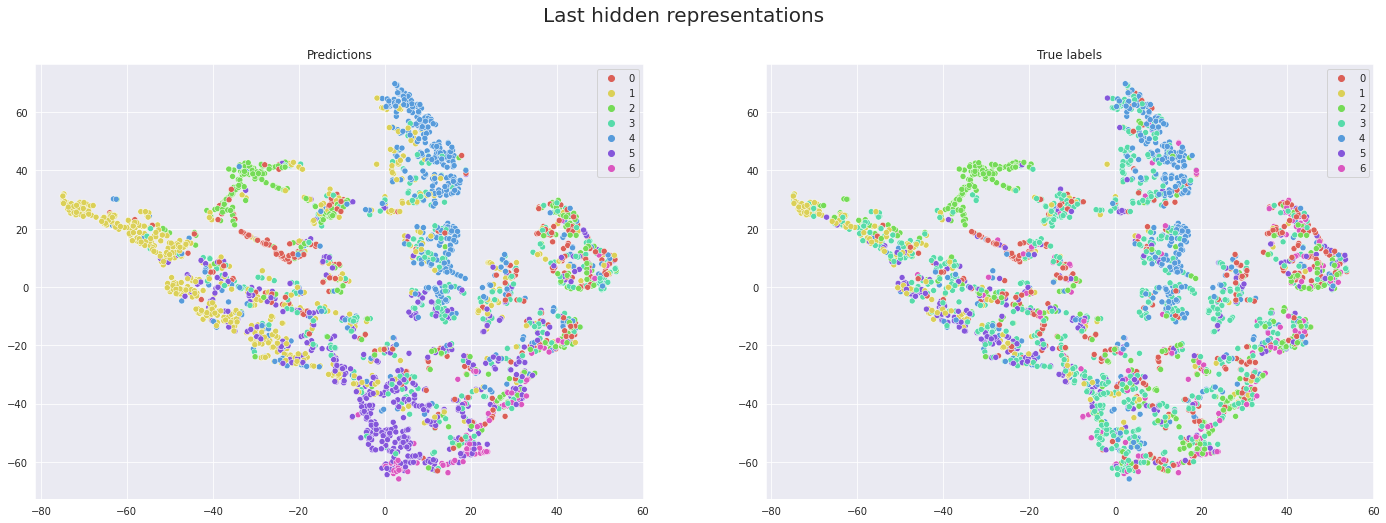

In [97]:
model = model_pipeline(config)